# Analysis of clusters of the end solutions of the participants

In [16]:
 import numpy as np
import numpy.random as npr
import os
import sys
import shutil
import matplotlib.pyplot as plt

currentdir = os.getcwd() 
parent_dir = os.path.dirname(currentdir)
sys.path.insert(0, parent_dir) 
from df_utils import *
#sys.path.insert(0,'../utils')
#print(sys.path)
from lp_utils import *

import pyomo.environ as pyo
import numpy as np
from pyomo.opt import SolverFactory
import matplotlib.pyplot as plt

from itertools import combinations_with_replacement, permutations, product
import pickle

import pandas as pd
import seaborn as sns

import networkx as nx
from pyvis.network import Network
from scipy.spatial import distance
from helper_solution_analysis import *


In [17]:
par_parent_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
data_file = 'data/online/full_experiment/data_furnituremanufacturing_2021-08-11_09-15.csv'
data_path = os.path.join(par_parent_dir, data_file)

# transform to dataframe
df, df_model, df_ge, df_vp_sol, df_qual,  df_actions, df_built, df_resources, df_play_times = decompose_csv(data_path)
df_complete_sol =  get_complete_sol(df_resources)

read cache


In [18]:
df_furn = get_furniture_dict(df_vp_sol, df_complete_sol)
df_profit, df_paths, df_leaves = generate_feasible_solutions(df_furn)


## Plot the clusters of solutions in the whole solution space in graphs

In [19]:
m = 12
minimum_d = 3
def draw_graph(m, minimum_d, show = True):
    df_graph = df_leaves.loc[df_leaves.month == m, ["solutions","profit","Number of solutions"]]
    df_graph = df_graph.fillna(0)
    G = Network( notebook = True)
    options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.9}
    #pos = nx.spring_layout(G, seed=3113794652)  # positions for all nodes
    #G.add_nodes_from(leaves)
    optima = []
    for s in range(len(df_graph)):
        if df_graph.iloc[s].profit ==df_graph.profit.max():
            optima.append(s)
            G.add_node(s,
                       label = str(int(df_graph.iloc[s].profit)), 
                       title= str(df_graph.iloc[s].solutions), 
                       size =df_graph.iloc[s]["Number of solutions"]*5+5,  color = '#954d5d')
        else:
            G.add_node(s,
                       label = str(int(df_graph.iloc[s].profit)),
                       title= str(df_graph.iloc[s].solutions), 
                       size =df_graph.iloc[s]["Number of solutions"]*5+5, color =  '#338899' )
    for s in range(len(df_graph)):
        for t in range(len(df_graph)):
          #  G.add_edge(e, n)
            #print(leaves[s])
            d = distance.euclidean(df_graph.iloc[s].solutions, df_graph.iloc[t].solutions)
            #print(d)# print(d)
            if d> 0 and d <minimum_d:
                G.add_edge(s, t,width = 5- 2*d)

    G.set_options("""const options = {
      "nodes": {
        "borderWidth": null,
        "borderWidthSelected": null,
        "opacity": 0.9,
        "size": null
      }
    }""")
    G.save_graph("Images/graphs/Graph_month" + str(m)+"_minimum_d_"+ str(minimum_d)+".html")
    if show:
        G.show("example.html")


In [20]:
for month in range (1,13):
    mind = 2
    draw_graph(month, mind, show = True)
    mind = 3
    draw_graph(month, mind, show = True)

## Plot the clusters of solutions in the whole solution space in Heatmap

In [21]:
df_profit, df_paths, df_sol = generate_feasible_solutions(df_furn)


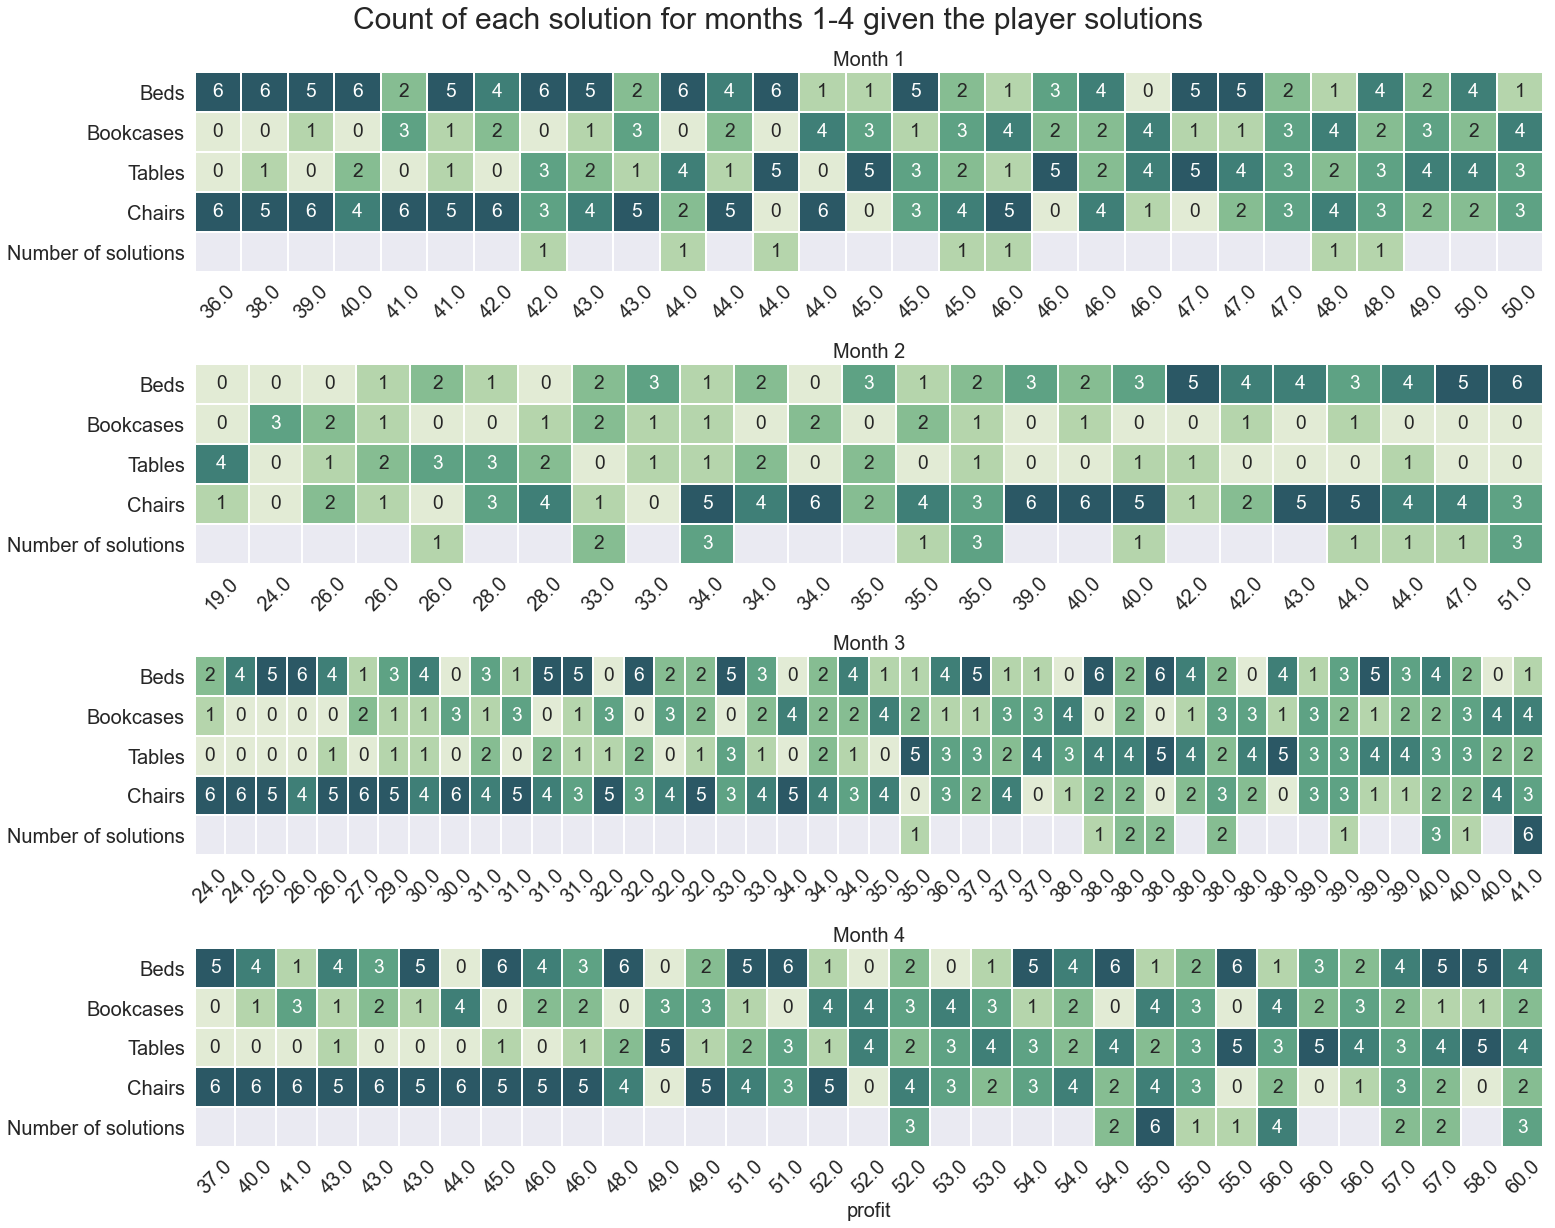

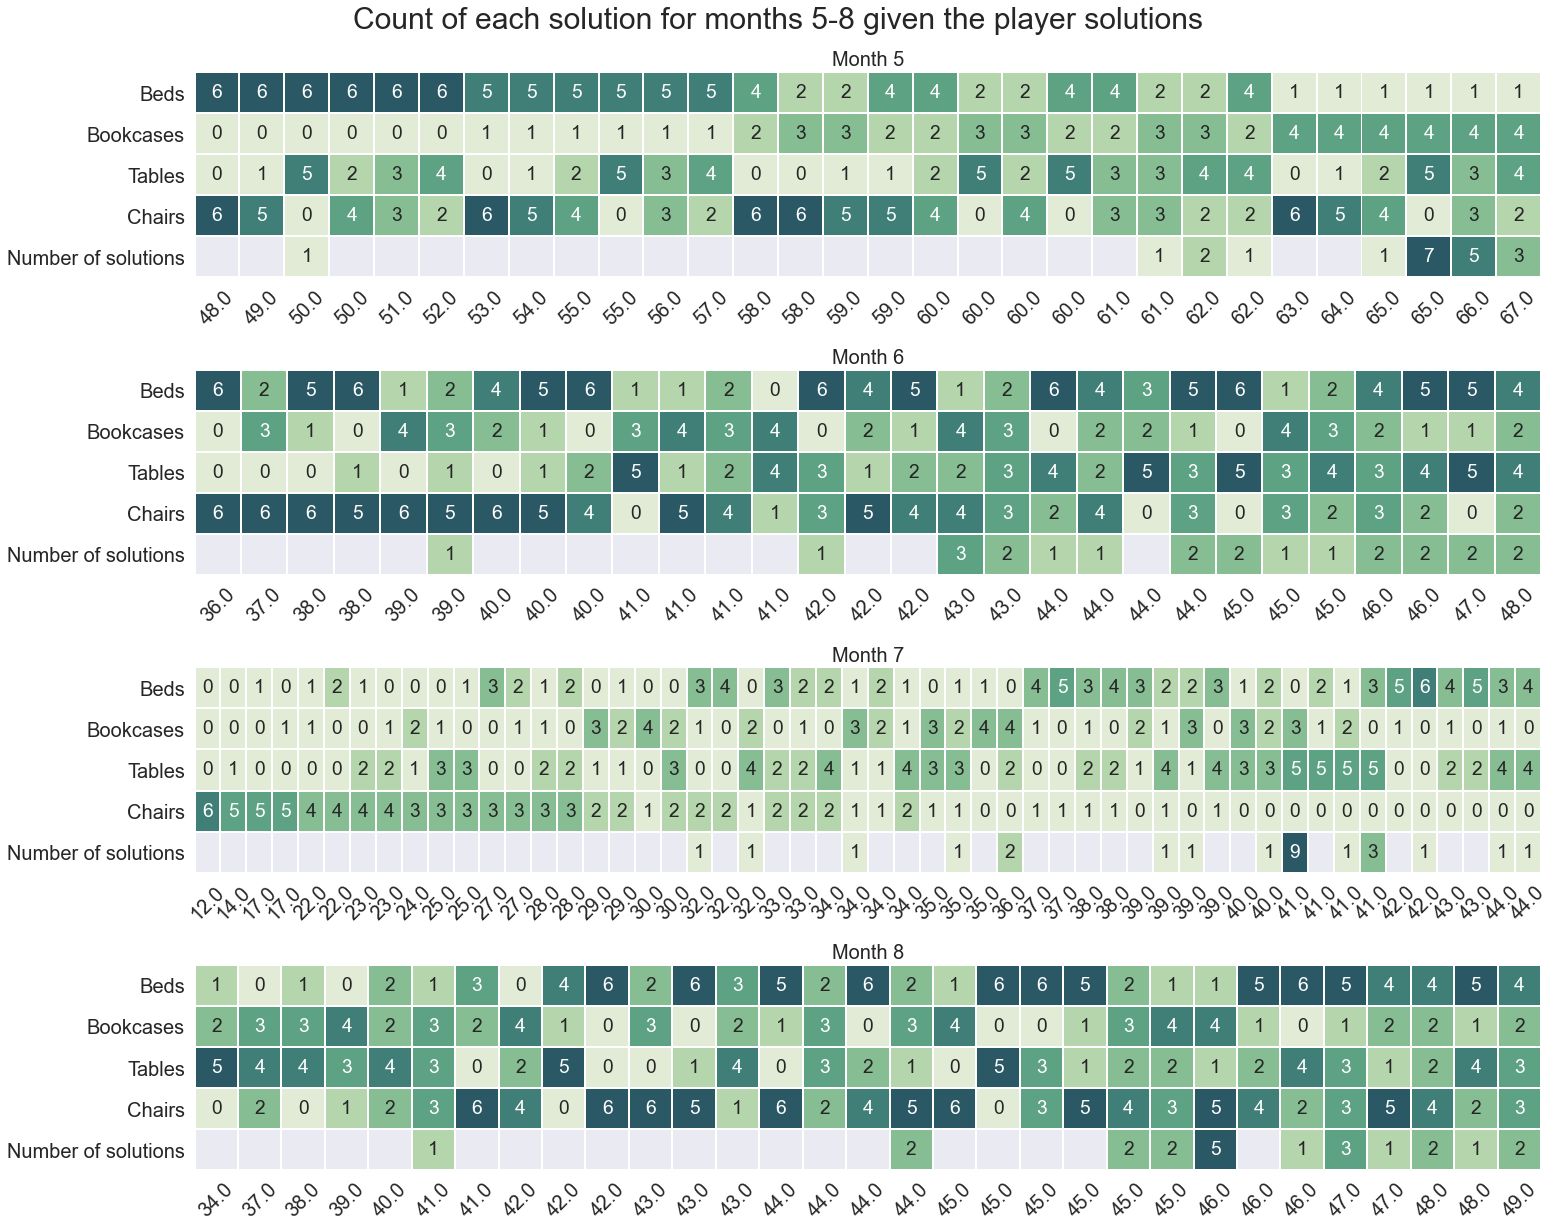

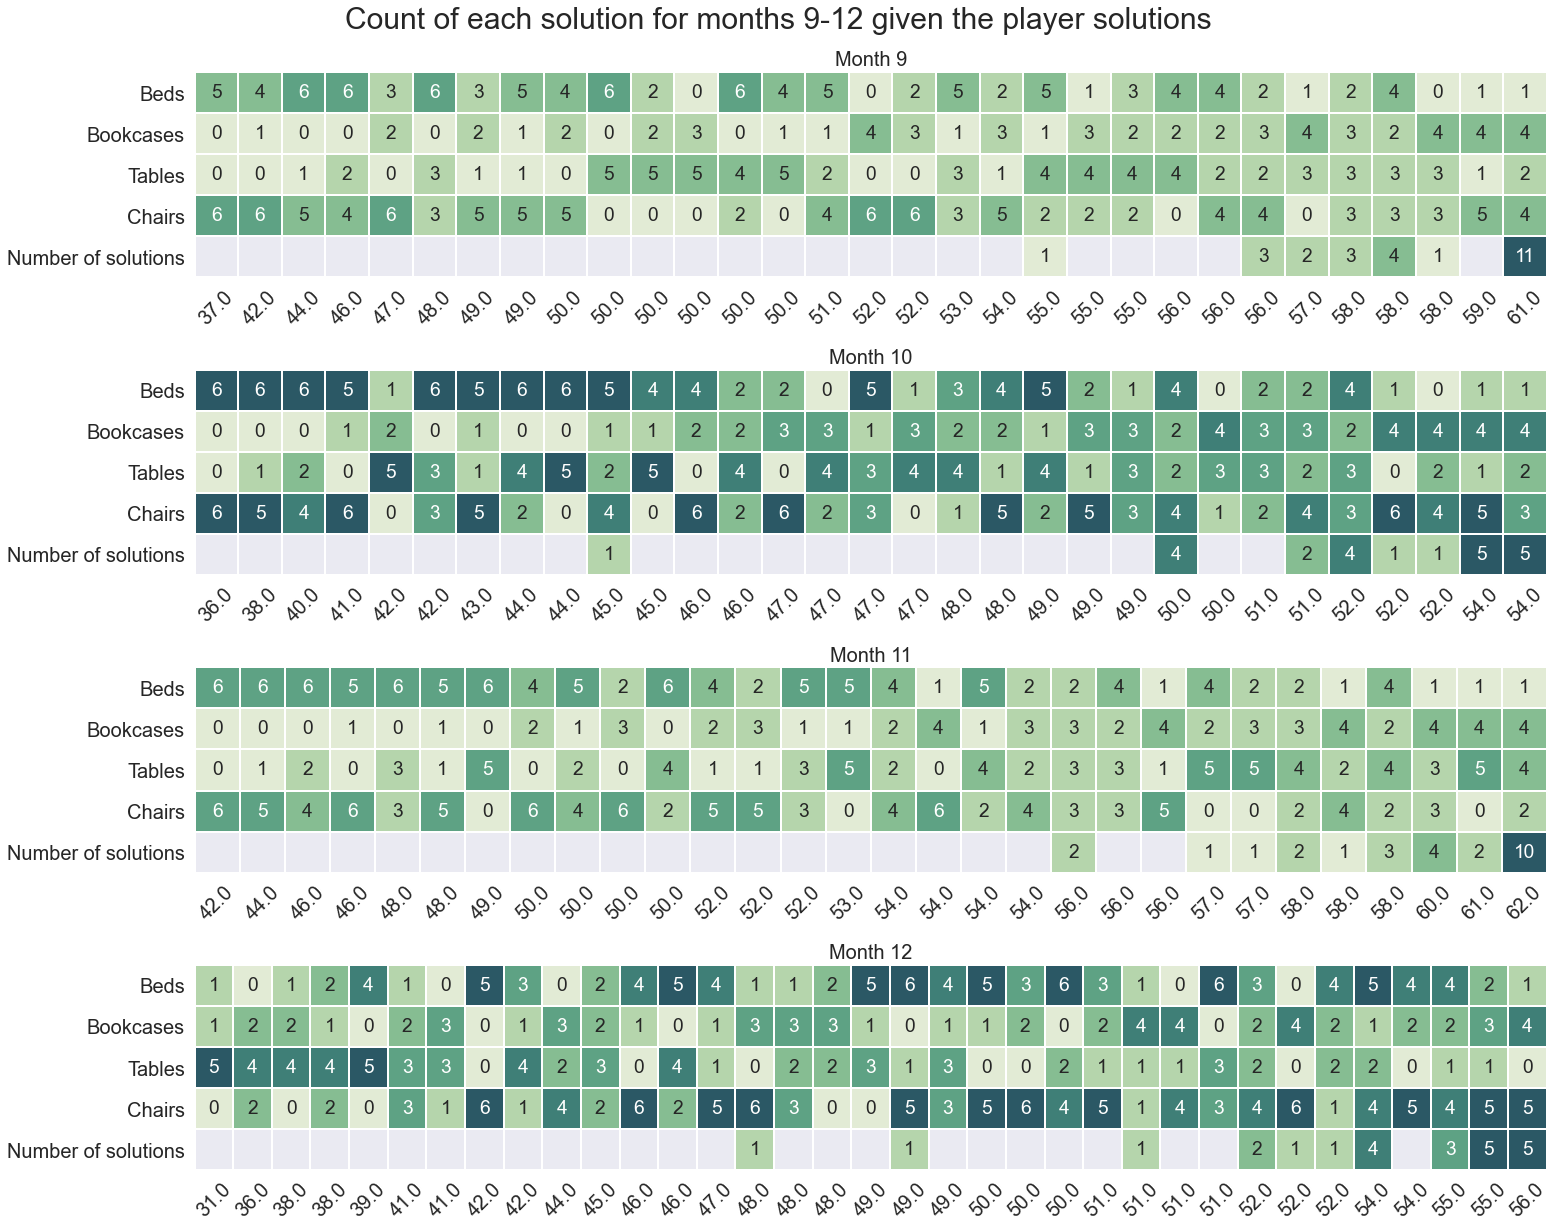

In [22]:
for f in range(3):  
    fig, axes = plt.subplots(4, 1, figsize=(22, 17.5))

    colormap =  sns.cubehelix_palette(n_colors=6, start=0, rot=-0.5, gamma=1.0, hue=0.8, light=0.9, dark=0.3)

    fig.suptitle('Count of each solution for months '+ str(f*4+1)+'-'+str(f*4+4)+' given the player solutions', fontsize = 30)
    c, j = 0,0
    for i in range(f*4,f*4+4):
        df_month = df_sol[df_sol.month == i+1]
        df_month = df_month.sort_values(by ='profit' )
        x_axis_labels = df_month['profit'] # labels for y-axis
        axes[c].set_title('Month {}'.format(i+1), fontsize = 20)
        sns.set(font_scale=1.6)

        sns.heatmap(ax = axes[c],
                    data = df_month[['Beds','Bookcases','Tables','Chairs', 'Number of solutions']].transpose() ,
                    cbar = None,
                    cmap = colormap,
                    xticklabels=x_axis_labels,  
                    annot = True, linewidths=1)
        if i == 3:
            axes[i].set_xlabel('profit', fontsize=20)
        c+=1
    for ax in axes:
        ax.tick_params(axis = 'y',labelrotation=0)
        ax.tick_params(axis = 'x',labelrotation=45)
        ax.tick_params(axis='both', which='major', labelsize=20)
    fig.tight_layout()
    fig.savefig('Images/furniture_composition_'+ str(f)+'_'+str(f+4)+'_vp_solutions.jpg')